In [1]:
# code taken from https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [2]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import json

Epoch 1/20


2023-06-24 03:52:55.630721: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/187 - 0s - loss: 0.0181 - 430ms/epoch - 2ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0118 - 119ms/epoch - 637us/step
Epoch 3/20
187/187 - 0s - loss: 0.0103 - 121ms/epoch - 648us/step
Epoch 4/20
187/187 - 0s - loss: 0.0090 - 156ms/epoch - 837us/step
Epoch 5/20
187/187 - 0s - loss: 0.0078 - 128ms/epoch - 687us/step
Epoch 6/20
187/187 - 0s - loss: 0.0068 - 115ms/epoch - 613us/step
Epoch 7/20
187/187 - 0s - loss: 0.0061 - 141ms/epoch - 756us/step
Epoch 8/20
187/187 - 0s - loss: 0.0056 - 146ms/epoch - 780us/step
Epoch 9/20
187/187 - 0s - loss: 0.0052 - 120ms/epoch - 644us/step
Epoch 10/20
187/187 - 0s - loss: 0.0046 - 115ms/epoch - 617us/step
Epoch 11/20
187/187 - 0s - loss: 0.0047 - 117ms/epoch - 626us/step
Epoch 12/20
187/187 - 0s - loss: 0.0045 - 118ms/epoch - 630us/step
Epoch 13/20
187/187 - 0s - loss: 0.0044 - 114ms/epoch - 612us/step
Epoch 14/20
187/187 - 0s - loss: 0.0042 - 115ms/epoch - 613us/step
Epoch 15/20
187/187 - 0s - loss: 0.0042 - 116ms/epoch - 620us/step
Epoch 16/20
187/1

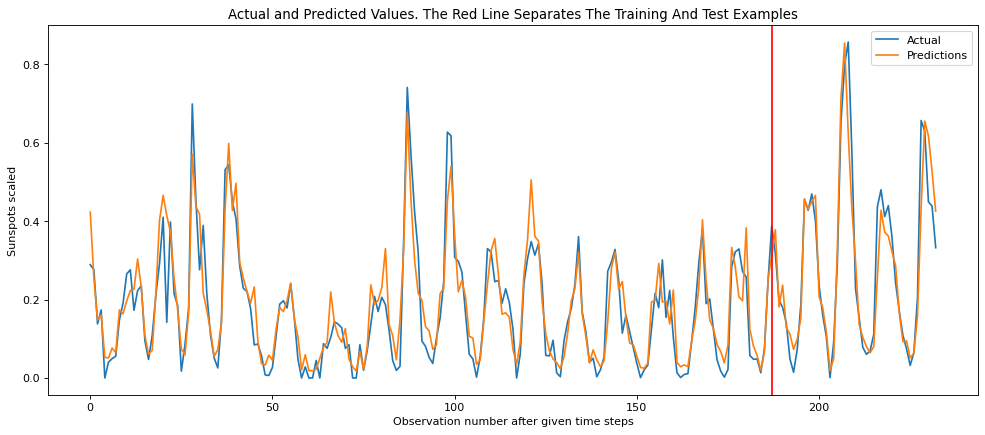

In [3]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['linear', 'linear'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [5]:
wx = model.get_weights()[0]
wh = model.get_weights()[1]
bh = model.get_weights()[2]
wy = model.get_weights()[3]
by = model.get_weights()[4]

print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-0.5854995  -0.45507526  0.12179769]]  wh =  [[-0.33120942  0.6775981  -0.09273831]
 [ 0.40508652 -0.11931774 -0.53312725]
 [ 0.47883147  0.13328932  0.22940747]]  bh =  [-0.00052628 -0.0016738   0.03834417]  wy = [[-0.5121936]
 [-0.5059854]
 [ 0.6776497]] by =  [0.00857583]


In [6]:
testX[0]

array([[0.52206457],
       [0.50630414],
       [0.33057526],
       [0.43065405],
       [0.45981082],
       [0.5133964 ],
       [0.57171   ],
       [0.5425531 ],
       [0.39676908],
       [0.49211976],
       [0.2931442 ],
       [0.3498818 ]], dtype=float32)

In [7]:
h = [np.zeros(3)]
for i in range(12):
    h.append(np.dot(testX[0][i], wx) + np.matmul(h[-1],wh) + bh)
    print([format(H, '.0f') for H in h[-1]*(10**(3*(i+2)))])
o12 = np.dot(h[-1], wy) + by

with open('out.json', 'w') as f:
    json.dump([format(H, '.0f') for H in h[-1]*(10**(3*(11+2)))] , f)

['-306195', '-239252', '101930']
['-243662957', '-397424039', '279342454']
['-140607632917', '-232562882659', '377165195190']
['-119712962850539', '-214908309978855', '314346677961412']
['-166632604918024832', '-224498177620083008', '292136996586817344']
['-196986133182510202880', '-282492378032784637952', '303032398209857028096']
['-239350949759771259961344', '-321224984587013965479936', '346367567783967825330176']
['-203187800621862081139834880', '-326265127061414808888803328', '377335991663344618938826752']
['-117021925322867632037771083776', '-230689195147071379021630537728', '366017547247864260134621413376']
['-168091762539832478971259131002880', '-228607626501771383820351097012224', '316089492355382414132718581317632']
['-57740765309533868392986021426364416', '-179566838745024007928836332216909824', '284027248432912520956363312853942272']
['-122996533897674423903599315268273176576', '-140738084101886857882830481745179049984', '247203695391081254414423297255165394944']


In [8]:
y = model.predict(testX[[0]])
print(y, o12)

1/1 [==============================] - 0s 12ms/step
[[0.31030276]] [0.31030279]


In [9]:
# quantization
params_json = {
    'wx': (wx*(10**3)).round().astype(int).astype(str).flatten().tolist(),
    'wh': (wh*(10**3)).round().astype(int).astype(str).flatten().tolist(),
    # 'b': (bh*(10**6)).round().astype(int).astype(str).flatten().tolist()
}

In [10]:
with open('params.json', 'w') as f:
    json.dump(params_json, f)

In [11]:
b = bh*float(10**3)
b_list = []
for i in range(12):
    b = [B*float(10**3) for B in b]
    b_str = [format(B,'.0f') for B in b]
    b_list.append(b_str)

with open("bias.json", "w") as f:
    json.dump(b_list, f)
b_list

[['-526', '-1674', '38344'],
 ['-526278', '-1673801', '38344170'],
 ['-526278019', '-1673800826', '38344169617'],
 ['-526278018951', '-1673800826073', '38344169616699'],
 ['-526278018951416', '-1673800826072693', '38344169616699216'],
 ['-526278018951416000', '-1673800826072692736', '38344169616699219968'],
 ['-526278018951415988224',
  '-1673800826072692686848',
  '38344169616699218198528'],
 ['-526278018951415966203904',
  '-1673800826072692781219840',
  '38344169616699216185262080'],
 ['-526278018951415991436836864',
  '-1673800826072692892888989696',
  '38344169616699214329836208128'],
 ['-526278018951415962299778727936',
  '-1673800826072692842311454818304',
  '38344169616699213379858161729536'],
 ['-526278018951415958359129053986816',
  '-1673800826072692927879847738343424',
  '38344169616699214316606884222599168'],
 ['-526278018951415943371149494097805312',
  '-1673800826072693052395370235882897408',
  '38344169616699215202050599760657645568']]

In [12]:
x = testX[0].flatten()
x_list = []
for i in range(12):
    x_str = format(x[i]*float(10**(3*(i+1))),'.0f')
    x_list.append(x_str)

with open("in.json", "w") as f:
    json.dump(x_list, f)
x_list

['522',
 '506304',
 '330575258',
 '430654048920',
 '459810823202133',
 '513396382331848128',
 '571709990501403787264',
 '542553126811981158809600',
 '396769076585769645155287040',
 '492119759321212790204790734848',
 '293144196271896328834732603211776',
 '349881798028945947987315674310508544']